In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
import torch

import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer.autoguide.guides import AutoNormal, AutoDelta

from pyro.optim import Adam
from pyro.infer import SVI

/Users/chigurh/miniconda3/envs/cellij/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import cellij

In [5]:
pyro.enable_validation(True)

In [6]:
from tqdm import tqdm

In [7]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using matplotlib backend: <object object at 0x17c831d80>


In [8]:
import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1.0,
    rc={"lines.linewidth": 5},
)

In [9]:
from cellij.core.synthetic import DataGenerator

In [10]:
n_samples = [101, 102, 103, 104]
n_features = [201, 202, 203, 204]
dg = DataGenerator(n_samples, n_features)
rng = dg.generate(all_combs=True)

Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.
Generating all possible binary combinations of 4 variables.
New factor configuration across `samples` groups: 1 fully shared, 10 partially shared, 4 private factors.
Generating all possible binary combinations of 4 variables.
New factor configuration across `features` groups: 1 fully shared, 10 partially shared, 4 private factors.


0
1
2
3


<AxesSubplot:>

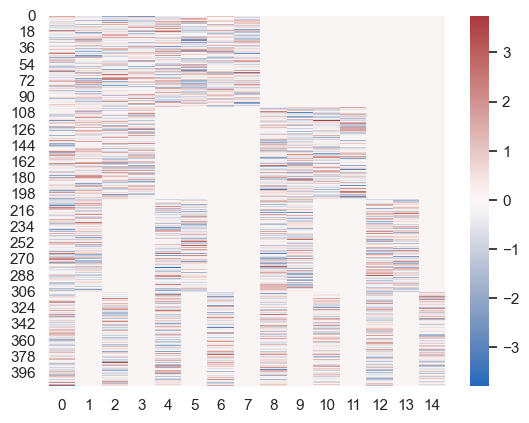

In [11]:
sns.heatmap(dg.z, center=0, cmap="vlag")

<AxesSubplot:>

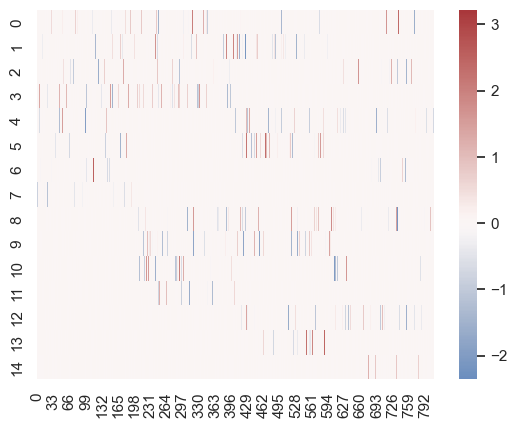

In [12]:
sns.heatmap(dg.w, center=0, cmap="vlag")

In [13]:
# # clean start
# print("Cleaning parameter store")
# pyro.clear_param_store()

In [14]:
model = cellij.core._pyro_models.Generative(
    n_factors=dg.n_factors,
    obs_dict={f"group_{g}": dg.n_samples[g] for g in range(dg.n_sample_groups)},
    feature_dict={f"view_{m}": dg.n_features[m] for m in range(dg.n_feature_groups)},
    likelihoods={f"view_{m}": "Normal" for m in range(dg.n_feature_groups)},
    factor_priors={
        "group_0": "Normal",
        "group_1": "Laplace",
        "group_2": "Horseshoe",
        "group_3": "Horseshoe",
    },
    weight_priors={
        "view_0": "Normal",
        "view_1": "Laplace",
        "view_2": "Horseshoe",
        "view_3": "Horseshoe",
    },
    device=torch.device("cpu"),
)

# autonormal_guide = AutoNormal(model)
guide = cellij.core._pyro_guides.Guide(model)

In [15]:
pyro.get_param_store().get_all_param_names()

dict_keys([])

In [16]:
for k, v in model().items():
    print(k, v.shape)

for k, v in guide().items():
    print(k, v.shape)

# for k, v in autonormal_guide().items():
#     print(k, v.shape)

for k, v in guide.sample_dict.items():
    print(v.shape == model.sample_dict[k].shape)

z_group_0 torch.Size([101, 15, 1])
z_group_1 torch.Size([102, 15, 1])
z_group_2 torch.Size([103, 15, 1])
z_group_3 torch.Size([104, 15, 1])
w_view_0 torch.Size([15, 201])
sigma_view_0 torch.Size([201])
w_view_1 torch.Size([15, 202])
sigma_view_1 torch.Size([202])
w_view_2 torch.Size([15, 203])
sigma_view_2 torch.Size([203])
w_view_3 torch.Size([15, 204])
sigma_view_3 torch.Size([204])
x_group_0_view_0 torch.Size([101, 201])
x_group_0_view_1 torch.Size([101, 202])
x_group_0_view_2 torch.Size([101, 203])
x_group_0_view_3 torch.Size([101, 204])
x_group_1_view_0 torch.Size([102, 201])
x_group_1_view_1 torch.Size([102, 202])
x_group_1_view_2 torch.Size([102, 203])
x_group_1_view_3 torch.Size([102, 204])
x_group_2_view_0 torch.Size([103, 201])
x_group_2_view_1 torch.Size([103, 202])
x_group_2_view_2 torch.Size([103, 203])
x_group_2_view_3 torch.Size([103, 204])
x_group_3_view_0 torch.Size([104, 201])
x_group_3_view_1 torch.Size([104, 202])
x_group_3_view_2 torch.Size([104, 203])
x_group_3_vi

In [17]:
for k, v in guide().items():
    print(k, v.shape)
    # print(v.shape == autonormal_guide()[k].shape)

z_group_0 torch.Size([101, 15, 1])
z_group_1 torch.Size([102, 15, 1])
z_group_2 torch.Size([103, 15, 1])
z_group_3 torch.Size([104, 15, 1])
w_view_0 torch.Size([15, 201])
sigma_view_0 torch.Size([201])
w_view_1 torch.Size([15, 202])
sigma_view_1 torch.Size([202])
w_view_2 torch.Size([15, 203])
sigma_view_2 torch.Size([203])
w_view_3 torch.Size([15, 204])
sigma_view_3 torch.Size([204])


In [18]:
data = {
    f"group_{g}": {
        f"view_{m}": torch.Tensor(dg.ys[g][m]) for m in range(dg.n_feature_groups)
    }
    for g in range(dg.n_sample_groups)
}

In [19]:
scale = 1.0 / len(dg.n_samples)
svi = SVI(
    pyro.poutine.scale(model, scale=scale),
    pyro.poutine.scale(guide, scale=scale),
    Adam({"lr": 0.005, "betas": (0.95, 0.999)}),
    loss=pyro.infer.Trace_ELBO(num_particles=3),
)

In [20]:
elbo_history = []
pbar = tqdm(range(1000))
for iteration_idx in pbar:
    elbo = svi.step(data)
    elbo_history.append(elbo)
    if iteration_idx % 100 == 0:
        pbar.set_postfix({"ELBO": elbo})

plt.plot(elbo_history)

 38%|███▊      | 377/1000 [05:20<09:08,  1.14it/s, ELBO=6.91e+6]

In [ ]:
pyro.get_param_store().get_all_param_names()

In [ ]:
sns.heatmap(dg.w, center=0, cmap="vlag")

In [ ]:
w_hat = np.concatenate([pyro.get_param_store().get_param(f"Normal.locs.w_view_{m}").squeeze().detach().numpy() for m in range(dg.n_feature_groups)], axis=1)
sns.heatmap(w_hat, center=0, cmap="vlag")

In [ ]:
pyro.get_param_store().get_param("Q.locs.z_group_1").squeeze().detach().numpy()

In [ ]:
guide.factor_q_dists["group_0"].locs.__dict__

In [ ]:
guide.factor_q_dists["group_0"].locs._parameters["z_group_0_unconstrained"].shape

In [ ]:
{k: v.shape for k, v in model.factor_priors["group_2"].sample_dict.items()}

In [ ]:
{k: v.shape for k, v in model.weight_priors["view_2"].sample_dict.items()}

In [ ]:
pyro.get_param_store().get_all_param_names()

In [ ]:
pyro.get_param_store().get_param("AutoNormal.locs.z_group_2_caux").shape

In [ ]:
pyro.get_param_store().get_param("AutoNormal.locs.w_view_2_caux").shape

In [ ]:
z_hat = (
    pyro.get_param_store()
    .get_param("AutoNormal.locs.z_group_0")
    .squeeze()
    .detach()
    .numpy()
)
ws_hat = []
ws_hat.append(
    pyro.get_param_store()
    .get_param("AutoNormal.locs.w_view_0")
    .squeeze()
    .detach()
    .numpy()
)
ws_hat.append(
    pyro.get_param_store()
    .get_param("AutoNormal.locs.w_view_1")
    .squeeze()
    .detach()
    .numpy()
)
ws_hat.append(
    pyro.get_param_store()
    .get_param("AutoNormal.locs.w_view_2_unconstrained")
    .squeeze()
    .detach()
    .numpy()
    * pyro.get_param_store()
    .get_param("AutoNormal.locs.w_view_2_lambdas")
    .squeeze()
    .detach()
    .numpy()
)

In [ ]:
sns.heatmap(dg.z, center=0, cmap="vlag")

In [ ]:
sns.heatmap(z_hat, center=0, cmap="vlag")

In [ ]:
for m in range(dg.n_feature_groups):
    sns.heatmap(dg.ws[m], center=0, cmap="vlag")
    plt.show()
    sns.heatmap(ws_hat[m], center=0, cmap="vlag")
    plt.show()